In [147]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Binary Classification

Here, we use a tabular dataset from kaggle (https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) with features on patients physical spine details possibly suited for classifying whether the person is 'abnormal' or 'normal' - possibly suffers back pain or not.   

We here just want to see how the training works with logistic regression (binary case). We set aside a proper handling of the learning experiment by splitting the data into a train and test partition (in general we would even have a validation partition). We focus here on making the system learn something. 

1. Download the dataset from kaggle (see the link in the notebook). Load it into a pandas dataframe (see the code in the notebook). Normalise the data.
2. Complete the code for the implementation of the methods \verb|predict|, \verb|cost|, \verb|gradient_cost|, \verb|accuracy|. As a test, just invoke the method by suitable dummy values.
3. Implement (full) batch GD for minimizing the CE cost (without autograd). Plot cost vs the number of epochs.
4. Implement (full) batch GD for minimizing the CE cost, this time with autograd. show that you obtain consistent results.
5. Tune the learning rate. What is a reasonable learning rate?

### 1. Load Data

In [148]:
import pandas as pd
df = pd.read_csv("./data/Dataset_spine.csv") # possibly modify!
df = df.drop(columns=['Unnamed: 13'])
N  = df.shape[0]
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


#### Normalization and Turning into Torch Tensors

In [149]:
x0 = torch.from_numpy(df.values[:,0:-1].astype(np.float64))
X = (x0-torch.mean(x0, dim=0))/torch.std(x0,dim=0)
Y = torch.tensor(('Abnormal'==df.values[:,-1])).int().reshape(-1,1)
print(X.shape, Y.shape)

torch.Size([310, 12]) torch.Size([310, 1])


### 2. Implement the Model for (Binary) Logistic Regression

Data:  $\,\qquad X = \left(\begin{array}{cccc} 1 & X_{11} & \dots & X_{1n} \\ \vdots & \vdots & \vdots & \vdots \\ 1 & X_{N1} & \dots & X_{Nn}\end{array}\right)\qquad$ and $\qquad Y = \left(\begin{array}{c} Y_{1} \\ \vdots \\ Y_{N} \end{array}\right)$

Model: $\qquad\hat{Y}(X;W) = \sigma\left(X W^\intercal\right) \qquad$ where $\qquad W = \left(\begin{array}{c} W_0 \\ W_1 \\ \vdots \\ W_n \end{array}\right)$

The model outputs the probability of observing in a sample $x$ a '1' (Abnormal).

Cost:  $\,\qquad C(W) = -\frac{1}{N}\sum_j \left(Y_j\log(\hat{Y}_j(X;W)) + (1-Y_j)\log(1-\hat{Y}_j(X;W))\right)$

__Remark:__ Note that the logarithm diverges at arguments approaching 0. Make sure that you don't run into numerical issues.

In [150]:
# compose torch tensors X of shape (N,13) by inserting a column with 1's as first column  
X = torch.cat((torch.ones(N,1),X), dim=1)
print(X)
print(X.shape)

tensor([[ 1.0000,  0.1468,  0.5006,  ...,  1.1652, -1.1947,  1.7096],
        [ 1.0000, -1.2439, -0.7476,  ...,  1.6768, -0.9388, -0.9125],
        [ 1.0000,  0.4836,  0.4672,  ...,  1.6333, -1.2252, -0.6147],
        ...,
        [ 1.0000,  0.0551,  0.5148,  ..., -1.0499,  1.4410, -0.6919],
        [ 1.0000, -0.8844, -0.8842,  ..., -0.7514,  1.6212,  0.7725],
        [ 1.0000, -1.5464, -1.2458,  ...,  0.6207,  1.2953,  1.4314]],
       dtype=torch.float64)
torch.Size([310, 13])


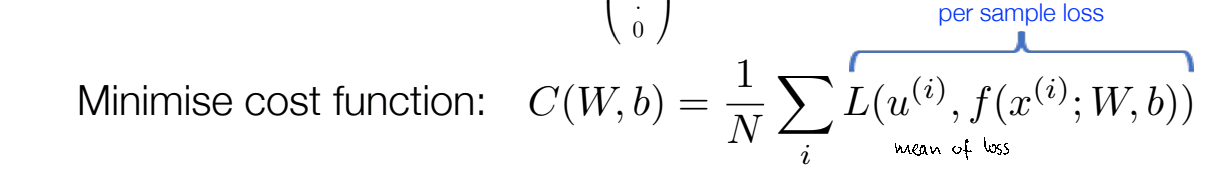

In [164]:
# implement methods for predicting the probability of having label 0 or 1 (W with shape (1,13))
def predict(X,W):
    # YOUR CODE (START)
    return torch.sigmoid(X@W.T)
    # YOUR CODE (END)

def cost(X,Y,W):
    # YOUR CODE (START)
    Yhat = predict(X,W)
    return -torch.mean(Y*torch.log(Yhat)+(1-Y)*torch.nan_to_num(torch.log(1-Yhat), neginf=-999)) # some values can be -inf => replace with a high negative number
    # YOUR CODE (END)

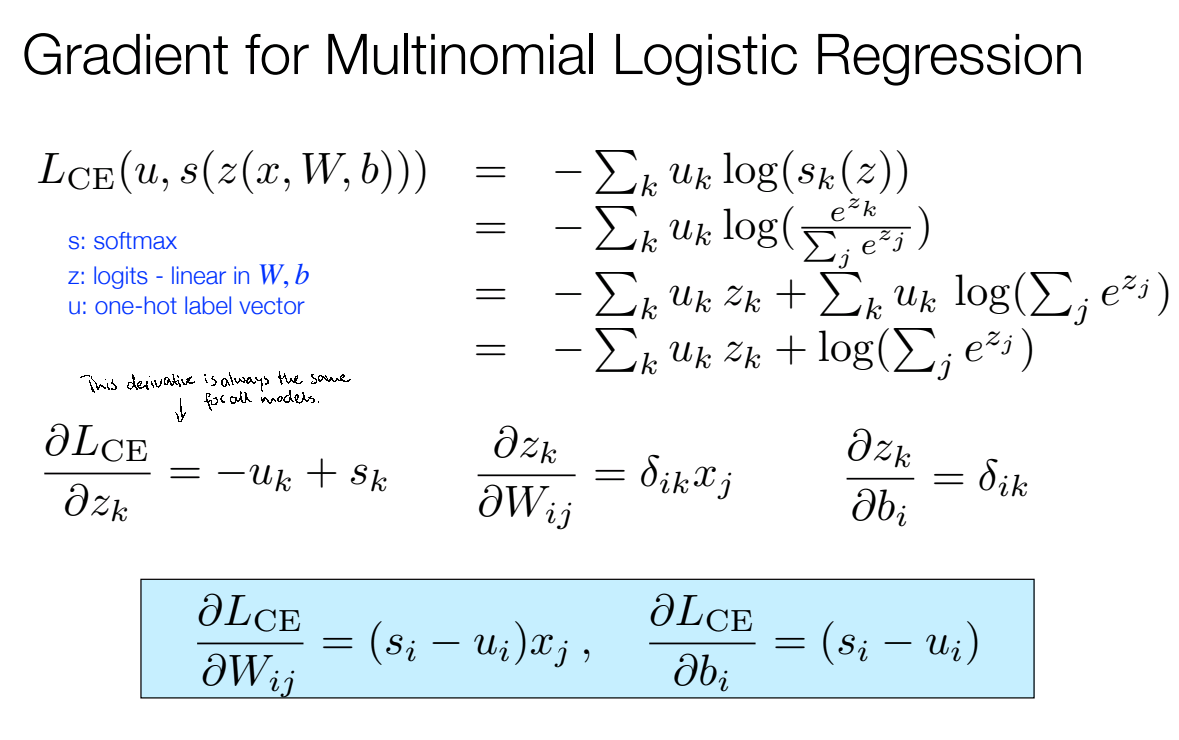

In [165]:
# def get_binary_one_hot(v):
#     ret = torch.zeros(1, 2)
#     if v.item() < 0.5:
#         ret[0, 0] = 1
#     else:
#         ret[0, 1] = 1
#     print(ret)
    
def gradient_cost(X,Y,W):
    # YOUR CODE (START)
    Yhat = predict(X,W)
    grad = X.T@(Yhat-Y)
    grad = grad.reshape(1,-1)
    return grad
    
def accuracy(Y,Yhat):
    # YOUR CODE (START)
    # Yhat = predict(X,W)
    # return torch.mean(1-abs(Y-Yhat))
    Yhat_int = torch.round(Yhat)
    acc = torch.sum(Yhat_int == Y)/Y.shape[0]     
    return acc  
    # YOUR CODE (END)

Just for testing:

In [166]:
W = torch.randn((1,13), dtype=torch.double)
print(predict(X[0],W))
print(cost(X,Y,W))
print(gradient_cost(X,Y,W))
print(accuracy(Y,predict(X,W)))

tensor([0.0976], dtype=torch.float64)
tensor(1.8732, dtype=torch.float64)
tensor([[ -80.0125,  -82.2630, -101.7915,  -48.0334,  -29.7372,   77.0894,
          -61.6688,   69.3852,   26.7533,   29.7821,    4.8405,   -0.6520,
           -1.1118]], dtype=torch.float64)
tensor(0.4129)


### 3. Implement Full Batch Gradient Descent

Training Accuracy (max,end): 0.841935, 0.800000
Training Cost (end): 92.739959


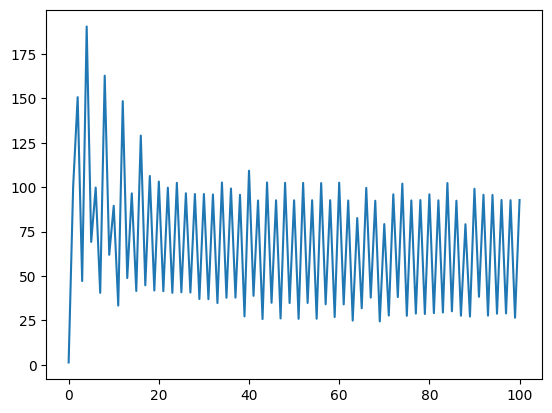

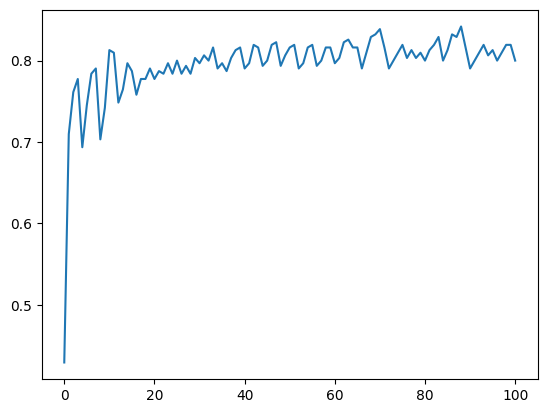

In [167]:
# adjust if needed
nepochs = 100
lr = 1.0

## initial parameter
W = torch.randn((1,13), dtype=torch.double)

# track the costs
costs = [cost(X,Y,W)]
accs = [accuracy(Y,predict(X,W))]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    W = W - lr * gradient_cost(X, Y, W)
    c = cost(X,Y,W)
    costs.append(c)
    a = accuracy(Y,predict(X,W))
    accs.append(a)
    #print("Epoch", epoch, ", cost =", c.item(), ", accuracy =", a.item())

# YOUR CODE (END)
    
# # some output
accs = np.array(accs)

print("Training Accuracy (max,end): %f, %f"%(np.max(accs), accs[-1]))
print("Training Cost (end): %f"%costs[-1].item())
plt.figure(1)
plt.plot(range(nepochs+1),costs)
plt.figure(2)
plt.plot(range(nepochs+1),accs)

### 4. Implement Full Batch Gradient Descent with Full-Fledge PyTorch

Training Accuracy (max,end): 0.864516, 0.864516
Training Cost (end): 0.332061


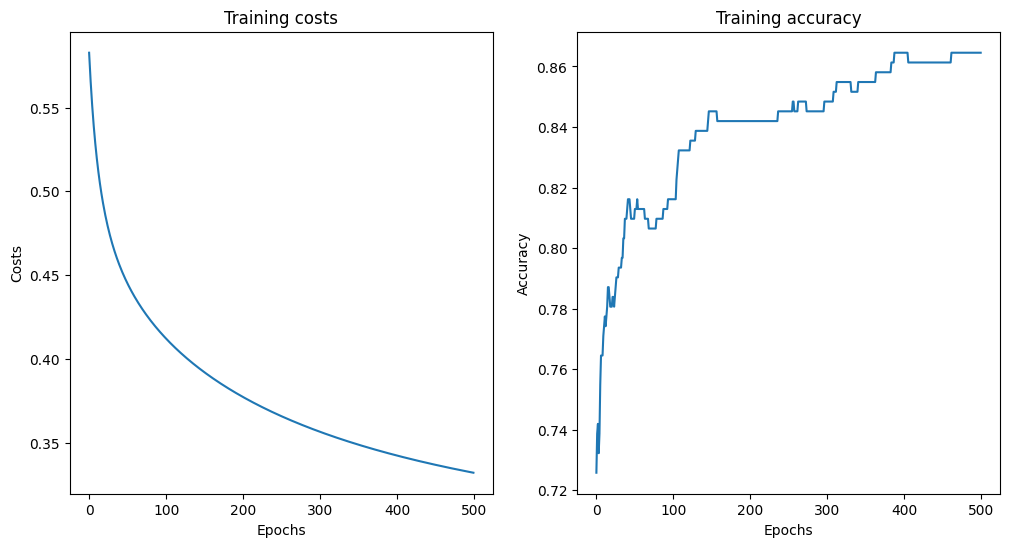

In [194]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, dtype=torch.float64)
     
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

# Transform datatype
Y = Y.type(torch.float64)

def do_training(nrepochs, learning_rate):
    input_dim = X.shape[1]
    output_dim = Y.shape[1]
    model = LogisticRegression(input_dim,output_dim)

    learning_rate = 0.1
    nepochs = 500
    cost = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    costs = []
    accs = []
    for epochs in range(nrepochs):
        pred = model(X)
        loss = cost(pred, Y)
        costs.append(loss.item())
        a = accuracy(Y, pred)
        accs.append(a)
        # gradient and parameter upate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return costs, accs

costs, accs = do_training(nrepochs=nepochs, learning_rate=learning_rate)
        
print("Training Accuracy (max,end): %f, %f"%(np.max(accs), accs[-1]))
print("Training Cost (end): %f"%costs[-1])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))    
ax[0].plot(costs)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Costs")
ax[0].set_title("Training costs")
ax[1].plot(accs)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Training accuracy")
plt.show()    

### 5. Tune Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

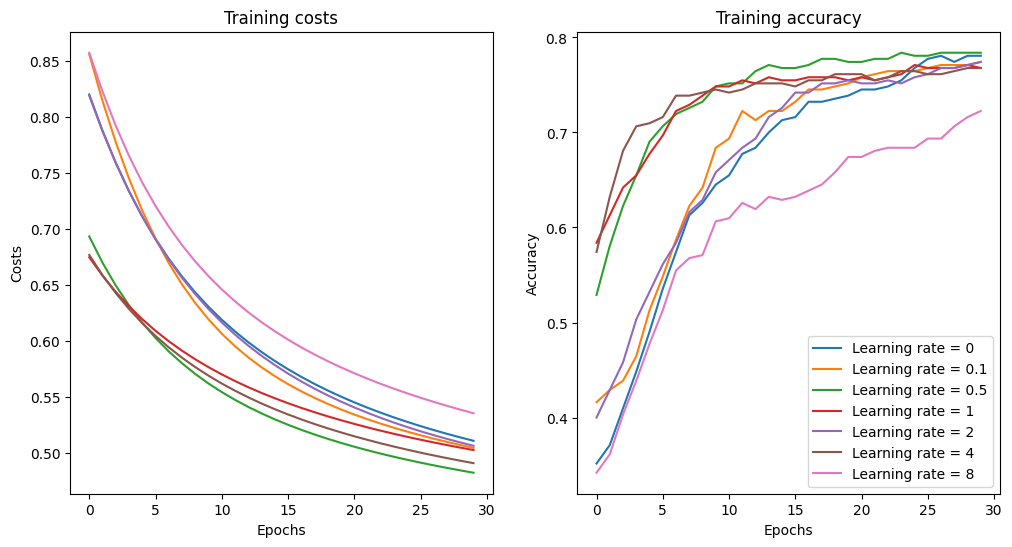

In [203]:
learning_rates = [0, 0.1, 0.5, 1, 2, 4, 8]
costLists = []
accLists = []

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))    
for lr in learning_rates:
    c, a = do_training(nrepochs=30, learning_rate=lr)
    costLists.append(c)
    accLists.append(a)
    ax[0].plot(costLists[-1], label="Learning rate = " + str(lr))
    ax[1].plot(accLists[-1], label="Learning rate = " + str(lr))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Costs")
ax[0].set_title("Training costs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Training accuracy")
plt.legend()

> Learning rate 0.5 works best in this case. None of the learning rates used seems problematic.